# Prepare model and dataset

In [5]:
from typing import Optional

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image

In [6]:
# Train on GPU if available

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
# Load CIFAR-100 dataset

input_size=32
num_workers = 2

transform_test = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

batch_size = 64

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers, pin_memory=True)

classes = ('apples', 'aquarium fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottles',
           'bowls', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'cans', 'castle', 'caterpillar', 'cattle', 'chair',
           'chimpanzee', 'clock', 'cloud', 'cockroach', 'computer keyboard', 'couch', 'crab', 'crocodile',
           'cups', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house',
           'kangaroo', 'lamp', 'lawn-mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple', 'motorcycle',
           'mountain', 'mouse', 'mushrooms', 'oak', 'oranges', 'orchids', 'otter', 'palm', 'pears', 'pickup truck',
           'pine', 'plain', 'plates', 'poppies', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
           'roses', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
           'streetcar', 'sunflowers', 'sweet peppers', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
           'train', 'trout', 'tulips', 'turtle', 'wardrobe', 'whale', 'willow', 'wolf', 'woman', 'worm')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# ResNet model definition

import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    """Basic Residual Block."""

    def __init__(
        self, in_channels: int, out_channels: int,
        stride: Optional[int] = 1, downsample: Optional[nn.Module] = None
    ) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward Pass."""
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        return out


class ResNet(nn.Module):
    """Residual Neural Network."""

    def __init__(self, num_classes: Optional[int] = 100, in_channels: Optional[int] = 32) -> None:
        super().__init__()

        # Pre
        self.in_channels = in_channels
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1, bias=False)
        self.bn = nn.BatchNorm2d(num_features=32)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=0.02)

        # Basic Blocks
        self.conv2_x = nn.Sequential(*[
            BasicBlock(32, 32) for i in range(4)
        ])

        self.conv3_x = nn.Sequential(BasicBlock(
            32, 64, 2,
            nn.Sequential(nn.Conv2d(32, 64, 3, 2, 1, bias=False), nn.BatchNorm2d(64))
        ))

        self.conv4_x = nn.Sequential(BasicBlock(
            64, 128, 2,
            nn.Sequential(nn.Conv2d(64, 128, 3, 2, 1, bias=False), nn.BatchNorm2d(128))
        ))

        self.conv5_x = nn.Sequential(BasicBlock(
            128, 256, 2,
            nn.Sequential(nn.Conv2d(128, 256, 3, 2, 1, bias=False), nn.BatchNorm2d(256))
        ))

        # Post
        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=1)
        self.fc_layer = nn.Linear(256, num_classes)

        # initialize weights

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)

        return x


In [9]:
# Initialize model

net = ResNet()
net.to(device)

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout2d(p=0.02, inplace=False)
  (conv2_x): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Load state dict

PATH = '/content/drive/MyDrive/models/resnet4000.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Export model to onnx format

In [12]:
pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 72.2 MB/s eta 0:00:00


In [13]:
import os
import numpy as np

net.eval()
input_shape = (1, 3, 32, 32)
model_name = "resnet4000"
save_directory = "."

X = torch.from_numpy(np.zeros(input_shape, dtype=np.float32)).to(device)
print(
    f"Saving model {model_name} in .onnx format"
)

torch.onnx.export(
    net,
    X,
    os.path.join(save_directory, model_name + ".onnx"),
    export_params=True,
    opset_version=10,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
)

Saving model resnet4000 in .onnx format
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



# Evaluate model performance

In [53]:
# compute top-k accuracy, confision matrix and accuracy per class

total = 0
net.eval()
ks = (1, 5) # top-k accuracy
correct = {k:0 for k in ks}

nb_classes = len(classes)
confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)

        # top-k accuracy
        total += labels.size(0)
        _, predicted = torch.topk(outputs.data, 5, 1, True, True)
        pred = predicted.t()
        correct_ = pred.eq(labels.view(1, -1).expand_as(pred))
        for k in ks:
          correct_k = correct_[:k].reshape(-1).float().sum(0)
          correct[k] += correct_k

        _, preds = torch.max(outputs.data, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

acc_top1 = float((correct[1]).cpu().numpy()) / total
acc_top5 = float((correct[5]).cpu().numpy()) / total

acc_per_class = {classes[i]: float(val.cpu().numpy()) for i, val in enumerate(confusion_matrix.diag() / confusion_matrix.sum(1))}

print(f'Accuracy: {100 * acc_top1:.2f}% (top1) {100 * acc_top5:.2f}% (top5)')
print(f'Confusion Matrix:\n {confusion_matrix}')
print(f'Accuracy per class: \n{acc_per_class}')

Accuracy: 62.35% (top1) 87.87% (top5)
Confusion Matrix:
 tensor([[81.,  1.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 83.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 47.,  ...,  0.,  1.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 51.,  0.,  0.],
        [ 0.,  0.,  7.,  ...,  0., 25.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0., 59.]])
Accuracy per class: 
{'apples': 0.8100000023841858, 'aquarium fish': 0.8299999833106995, 'baby': 0.4699999988079071, 'bear': 0.5199999809265137, 'beaver': 0.3199999928474426, 'bed': 0.6700000166893005, 'bee': 0.699999988079071, 'beetle': 0.6200000047683716, 'bicycle': 0.6800000071525574, 'bottles': 0.7400000095367432, 'bowls': 0.3799999952316284, 'boy': 0.4000000059604645, 'bridge': 0.7699999809265137, 'bus': 0.5299999713897705, 'butterfly': 0.5799999833106995, 'camel': 0.5, 'cans': 0.7200000286102295, 'castle': 0.800000011920929, 'caterpillar': 0.5699999928474426, 'cattle': 0.5400000214576721, 'chair': 0.800000011920929, 'chimpanzee': 0.7099999

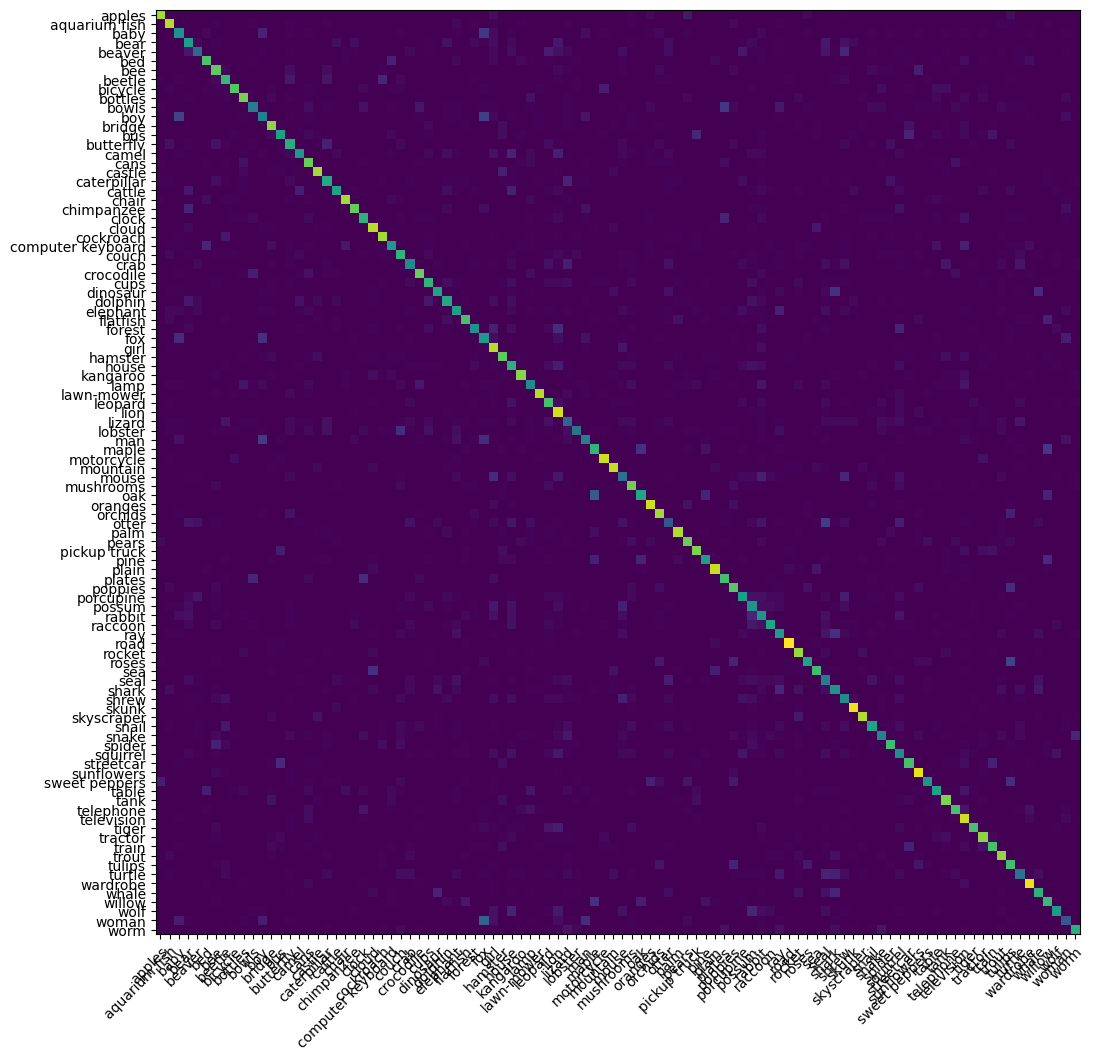

In [ ]:
# Visualize confusion matrix

import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(14, 12))

ax.set_yticks(np.arange(len(classes)), labels=classes)
ax.set_xticks(np.arange(len(classes)), labels=classes)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.imshow(confusion_matrix)

<BarContainer object of 100 artists>

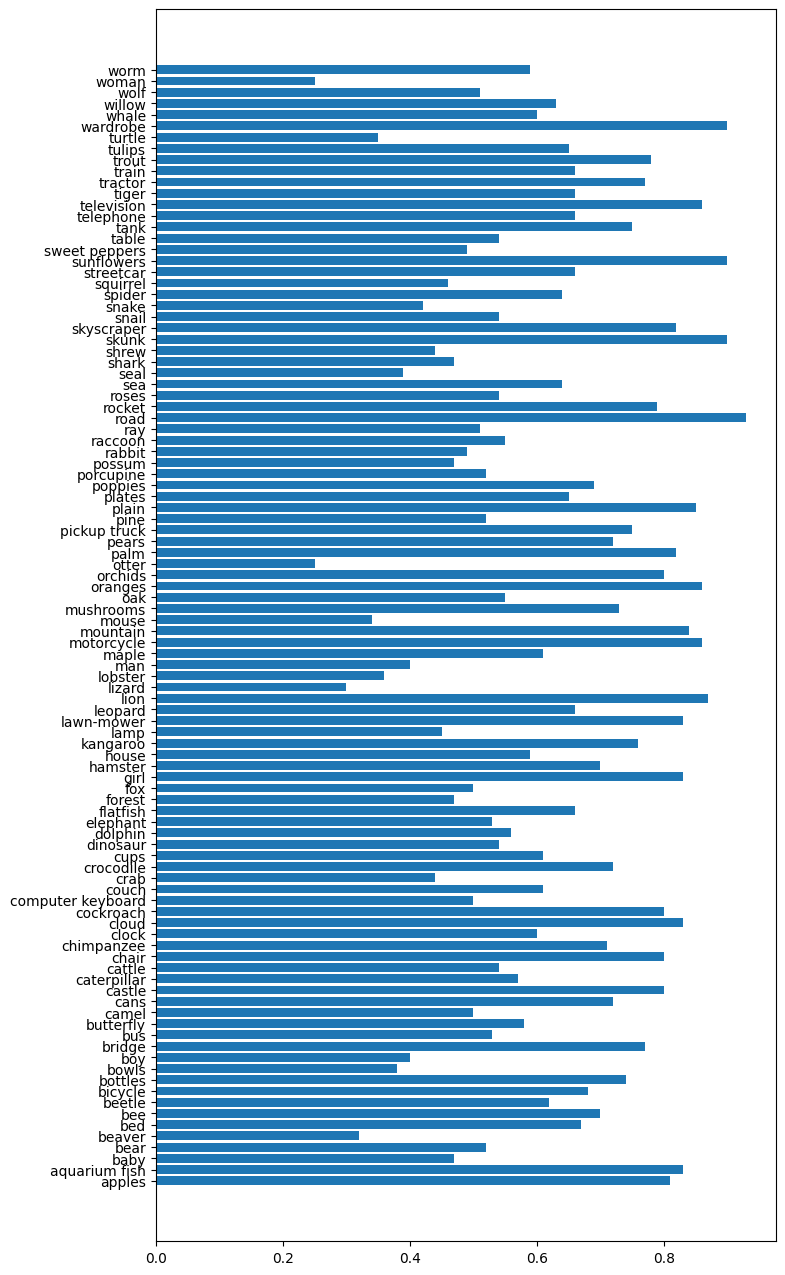

In [ ]:
# Visualize accuracy per class

import matplotlib.pyplot as plt

acc_vals = acc_per_class.values()

fig, ax = plt.subplots(figsize=(8, 16))
ax.barh(classes, acc_vals, align='center')


{'streetcar': 0.66056955,
 'train': 0.33621225,
 'bus': 0.0029543934,
 'bridge': 0.00019828077,
 'pickup truck': 5.7097343e-05}

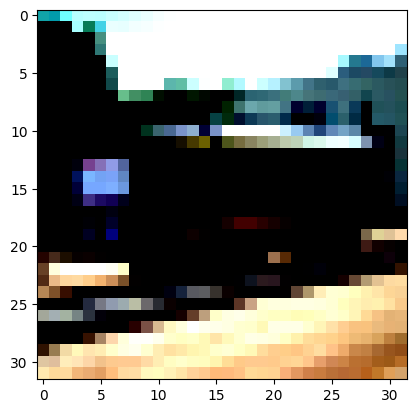

In [99]:
# Run inference on an individual image from the dataset

dataiter = iter(testloader)
images, labels = next(dataiter)

img1 = images[None, 12, :, :, :].to(device)
plt.imshow(img1.cpu().squeeze().permute(1,2,0))
label1 = labels[0]
val, ind = torch.topk(F.softmax(net(img1).data, dim=1), k=5)
val, ind = val.cpu().numpy(), ind.cpu().numpy()
{classes[ind[0][i]]:val[0][i] for i in range(val.size)}


Files already downloaded and verified


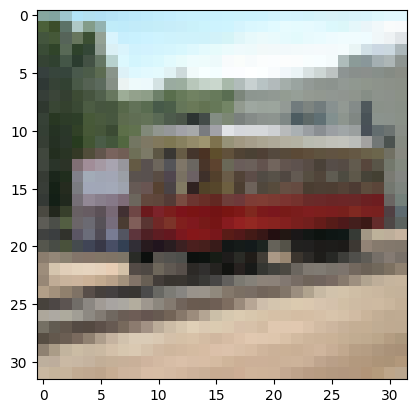

In [98]:
# Load a random image from CIFAR-100 dataset

tt = transforms.Compose(
    [
     transforms.ToTensor(),
])
ts = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=tt)
tl = torch.utils.data.DataLoader(ts, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers, pin_memory=True)
di = iter(tl)
i, l = next(di)

imgu = i[None, 12, :, :, :].to(device)
plt.imshow(imgu.cpu().squeeze().permute(1,2,0))

In [101]:
# Save untransformed image

print(imgu)
save_image(imgu, 'caru.jpg')

tensor([[[[0.5255, 0.5098, 0.6235,  ..., 0.8706, 0.8863, 0.8863],
          [0.2941, 0.2314, 0.3608,  ..., 0.9451, 0.9765, 0.9725],
          [0.2627, 0.2706, 0.3373,  ..., 0.9412, 0.9333, 0.8824],
          ...,
          [0.5569, 0.6667, 0.7608,  ..., 0.6824, 0.6667, 0.6588],
          [0.7412, 0.7412, 0.7922,  ..., 0.6784, 0.6706, 0.6980],
          [0.7882, 0.7725, 0.7804,  ..., 0.7098, 0.7412, 0.7294]],

         [[0.6510, 0.6431, 0.7765,  ..., 0.9686, 0.9686, 0.9686],
          [0.3765, 0.3020, 0.4471,  ..., 0.9725, 0.9843, 0.9804],
          [0.3333, 0.3451, 0.3922,  ..., 0.9686, 0.9490, 0.8980],
          ...,
          [0.5059, 0.6118, 0.7059,  ..., 0.5922, 0.5725, 0.5647],
          [0.6863, 0.6784, 0.7255,  ..., 0.5804, 0.5765, 0.5961],
          [0.7216, 0.7059, 0.7059,  ..., 0.6078, 0.6471, 0.6510]],

         [[0.6235, 0.6275, 0.8078,  ..., 0.9882, 0.9922, 0.9922],
          [0.2235, 0.1647, 0.4039,  ..., 0.9804, 0.9843, 0.9843],
          [0.2392, 0.2196, 0.3490,  ..., 0

In [108]:
# Run inference on a PIL Image

from PIL import Image

img_name = "caru.jpg"
img_raw2 = np.array(Image.open(img_name)).astype(np.float32) / 255.0

tr = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

img2plus = tr(img_raw2)[None, :, :, :].to(device)
print(img2plus[0][0])

val, ind = torch.topk(F.softmax(net(img2plus).data, dim=1), k=5)
val, ind = val.cpu().numpy(), ind.cpu().numpy()
{classes[ind[0][i]]:val[0][i] for i in range(val.size)}

tensor([[ 0.2308,  0.2161,  0.6421,  ...,  1.4499,  1.4352,  1.3764],
        [-0.8267, -0.9148, -0.3420,  ...,  1.3324,  1.4646,  1.6408],
        [-0.7973, -1.1939, -0.6945,  ...,  1.5527,  1.4058,  1.3324],
        ...,
        [ 0.2455,  0.5099,  0.8183,  ...,  0.6568,  0.5833,  0.5539],
        [ 0.8036,  0.9505,  1.1121,  ...,  0.5393,  0.5246,  0.5246],
        [ 0.9946,  0.9652,  0.9211,  ...,  0.6568,  0.7302,  0.7889]],
       device='cuda:0')


{'streetcar': 0.7573462,
 'train': 0.23100619,
 'bus': 0.010043852,
 'bridge': 0.0010469332,
 'pickup truck': 0.0004819481}